<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data-and-set-environment" data-toc-modified-id="Get-data-and-set-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data and set environment</a></span></li><li><span><a href="#inspect-data" data-toc-modified-id="inspect-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>inspect data</a></span></li><li><span><a href="#read-audios,-zero-pad-them,-create-spectrograms,-create-valid-and-train-datasets" data-toc-modified-id="read-audios,-zero-pad-them,-create-spectrograms,-create-valid-and-train-datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>read audios, zero-pad them, create spectrograms, create valid and train datasets</a></span></li><li><span><a href="#check-out-spectrograms" data-toc-modified-id="check-out-spectrograms-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>check out spectrograms</a></span></li><li><span><a href="#Model-architecture" data-toc-modified-id="Model-architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model architecture</a></span></li><li><span><a href="#Compile-and-train" data-toc-modified-id="Compile-and-train-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compile and train</a></span></li><li><span><a href="#Plot-learning-curves" data-toc-modified-id="Plot-learning-curves-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot learning curves</a></span></li><li><span><a href="#Predict-on-subset-of-validation-set" data-toc-modified-id="Predict-on-subset-of-validation-set-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Predict on subset of validation set</a></span></li></ul></div>

In [ ]:
!pip install soundfile 

In [41]:
!nvidia-smi

Mon Jun 28 15:49:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    59W / 149W |   5506MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get data and set environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile
import os
import soundfile as sf
import IPython
import random
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models,layers,losses,optimizers,backend,metrics
from tensorflow.keras.layers import Input, Add,Dense, BatchNormalization, Conv1D, Conv1DTranspose, MaxPool1D, Dropout,Flatten
from tensorflow.keras.models import Model

In [ ]:
# get macaques dataset from ESP, unzip, and examine
!wget https://archive.org/download/macaque_coo_calls/macaques.zip
!unzip /content/macaques.zip
!ls /content

### inspect data

In [2]:
# create pandas dataframe with 'annotations.csv' content
df=pd.read_csv('/content/annotations.csv')
df.head(10)

,class,split,filename
0,TH,train,TH28.wav
1,TH,train,TH22.wav
2,TH,train,TH928.wav
3,TH,train,TH1145.wav
4,TH,valid,TH470.wav
5,TH,train,TH372.wav
6,TH,train,TH941.wav
7,TH,train,TH920.wav
8,TH,valid,TH791.wav
9,TH,valid,TH565.wav


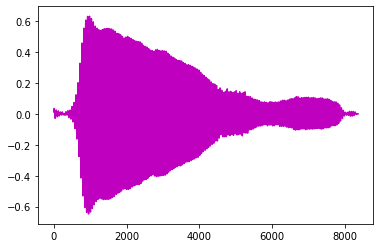

samplerate= 24414


In [97]:
# randomly choose a filename from dataframe, then plot time-series and display audio
index=random.randrange(len(df))
filepath = os.path.join('/content',df.iloc[index].split,df.iloc[index].filename)
data, samplerate = sf.read(filepath)
plt.plot(data,'m')
plt.show()
print('samplerate=',samplerate)
IPython.display.Audio(data=data,rate=samplerate)


### read audios, zero-pad them, create spectrograms, create valid and train datasets 

In [6]:
# give filepath, get audio
def read_audio(filepath):
  audio_binary = tf.io.read_file(filepath)
  audio, samplerate = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)


In [7]:
# zero-pad all audio signals to same length.
# max length was determined by checking all audio - after inserting them in df. 
# Skipped this part here for simplicity (np.max(df['time-series'].apply(lambda x : len(x))))
def zero_pad_t_series(signals):
  max_len=41307
  zero_ext = tf.zeros([max_len] - tf.shape(signals), dtype=tf.float32)
  signal = tf.cast(signals, tf.float32)
  signals_padded=tf.concat([signal, zero_ext], 0)
  return signals_padded

In [8]:
# create spectrograms from audio signals after applying zero-padding first (returns abs of spectrogram, i.e. ignoring phase at the moment)
def create_spectrograms(signal):
  fft_l=512
  frame_l=512
  frame_s=128
  signal_padded=zero_pad_t_series(signal)
  signal_padded=signal_padded[:16384] # hand selected max length for faster training
  spectrogram = tf.signal.stft(signal_padded, fft_length=fft_l,frame_length=frame_l, frame_step=frame_s,pad_end=True)
  return spectrogram, signal_padded 

In [82]:
# use tf.data to create pipelines for our datasets
def create_datasets(filepaths):
  dataset_filepaths = tf.data.Dataset.from_tensor_slices(filepaths)
  dataset = dataset_filepaths.map(read_audio,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(create_spectrograms,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return dataset

In [83]:
# let's create train and valid lists, which will contain the file location of their members

train_filenames=('/content/train/'+df.loc[df['split']=='train','filename']).values.tolist()
valid_filenames=('/content/valid/'+df.loc[df['split']=='valid','filename']).values.tolist()


In [84]:
train_dataset = create_datasets(train_filenames)
valid_dataset = create_datasets(valid_filenames)

### check out spectrograms

In [15]:
for spectrogram,audio  in train_dataset.take(1):
  input_shape = spectrogram.shape
print('Spectrogram dimensions:',input_shape)


Spectrogram dimensions: (128, 257)


In [16]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<ipython-input-16-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-16-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


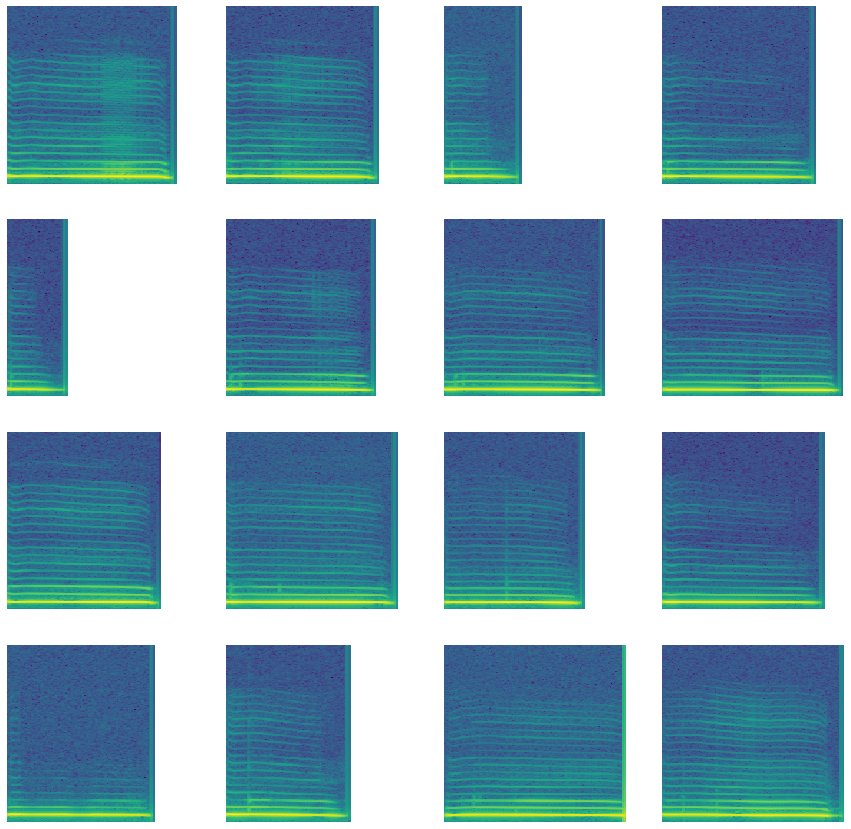

In [17]:
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for i, (spectrogram, audio) in enumerate(train_dataset.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(tf.abs(spectrogram).numpy()), ax)
  ax.axis('off')
  
plt.show()

### Model architecture

In [85]:
backend.clear_session()

In [86]:
PARAMS = {'lr': 1e-3,   
          'dropout': 0.0,
          'batch_size': 16,
          'n_epochs': 80,
          'optimizer': 'Adam',
          'loss': 'mse',
          'metrics': 'mae',
          'activations': 'relu, tanh',
          'spectrogram_input_shape' : (128,257),
          'run env' : 'Themistoclea', 
          'data' : 'macaque coos dataset from ESP library.',  
          'save_model': 'STFT_inv_mac_conv1D_res.h5',
          'notebook' : 'STFT_decoder_conv1D_res.ipynb',
          'NOTES' : ''
          }

In [87]:
train_dataset = train_dataset.batch(PARAMS['batch_size'])
valid_dataset = valid_dataset.batch(PARAMS['batch_size'])

train_dataset=train_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset=valid_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)


In [89]:

input_layer=Input(shape=PARAMS["spectrogram_input_shape"])

c0=Conv1D(128, (3), activation='relu',strides=1,padding='same')(input_layer)
c0=BatchNormalization()(c0)   
c1=Conv1D(128, (3), activation='relu',strides=1,padding='same')(c0)
c1=layers.BatchNormalization()(c1)
c2=Conv1D(128, (3), activation='relu',strides=1,padding='same')(c1)
c2=BatchNormalization()(c2)

res1 = Add()([c0,c2])

c3 = Conv1D(64,(3),activation='relu',strides=1,padding='same')(res1)
c3=BatchNormalization()(c3)

c4 = Conv1D(64,(3),activation='relu',strides=2,padding='same')(c3)
c4=BatchNormalization()(c4)

cT1=Conv1DTranspose(128, (3), activation='relu',strides=2,padding='same')(c4)
cT1=BatchNormalization()(cT1)

c5=Conv1D(128, (3), activation='relu',strides=1,padding='same')(cT1)
c5=BatchNormalization()(c5)
c6=Conv1D(128, (3), activation='relu',strides=1,padding='same')(c5)
c6=BatchNormalization()(c6)

res2=Add()([cT1,c6])

cT2=Conv1DTranspose(128, (3), activation='relu',strides=1,padding='same')(res2)
cT2=BatchNormalization()(cT2)
cT2=Conv1DTranspose(257, (3), activation='relu',strides=1,padding='same')(cT2)
cT2=BatchNormalization()(cT2)
output=Conv1DTranspose(1,(512),strides=128,activation='tanh',padding='same')(cT2)

model = Model(inputs=input_layer, outputs=output)

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 257)]   0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 128, 128)     98816       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128)     512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 128, 128)     49280       batch_normalization_10[0][0]     
_______________________________________________________________________________________

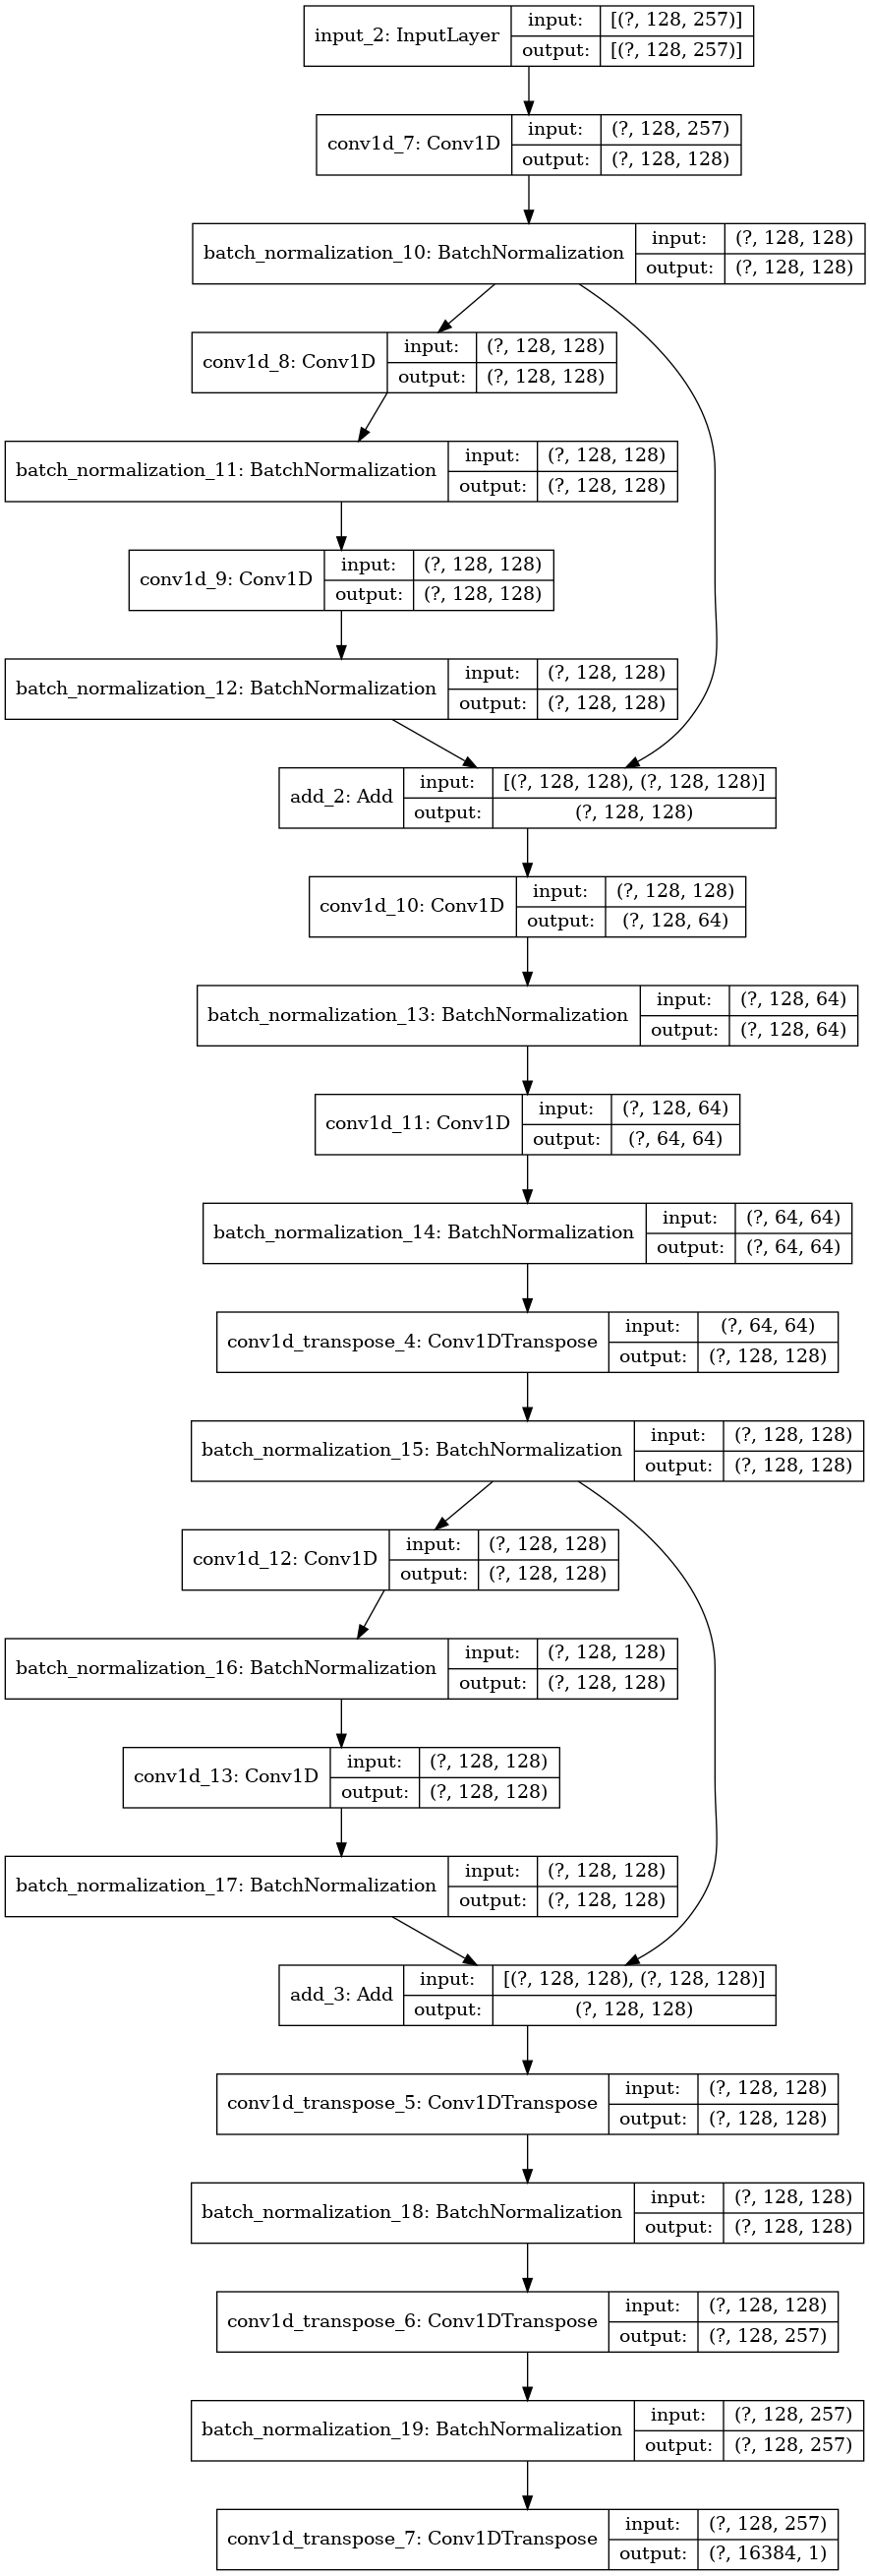

In [90]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

### Compile and train

In [91]:
model.compile(optimizer=optimizers.Adam(learning_rate=PARAMS['lr']), loss=PARAMS['loss'],metrics=PARAMS['metrics'])

In [92]:
history=model.fit(train_dataset,
                epochs=PARAMS['n_epochs'],
                shuffle=True, 
                validation_data=valid_dataset)

#model.save(PARAMS['save_model'])

Epoch 1/80
365/365 [==============================] - 14s 38ms/step - loss: 0.0059 - mae: 0.0445 - val_loss: 0.0541 - val_mae: 0.1212
Epoch 2/80
365/365 [==============================] - 12s 33ms/step - loss: 0.0052 - mae: 0.0415 - val_loss: 0.0349 - val_mae: 0.1060
Epoch 3/80
365/365 [==============================] - 13s 35ms/step - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0153 - val_mae: 0.0679
Epoch 4/80
365/365 [==============================] - 12s 33ms/step - loss: 0.0033 - mae: 0.0336 - val_loss: 0.0081 - val_mae: 0.0522
Epoch 5/80
365/365 [==============================] - 12s 34ms/step - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0048 - val_mae: 0.0430
Epoch 6/80
365/365 [==============================] - 12s 34ms/step - loss: 0.0018 - mae: 0.0262 - val_loss: 0.0034 - val_mae: 0.0351
Epoch 7/80
365/365 [==============================] - 12s 34ms/step - loss: 0.0015 - mae: 0.0246 - val_loss: 0.0027 - val_mae: 0.0315
Epoch 8/80
365/365 [==============================] - 13s 36ms

### Plot learning curves

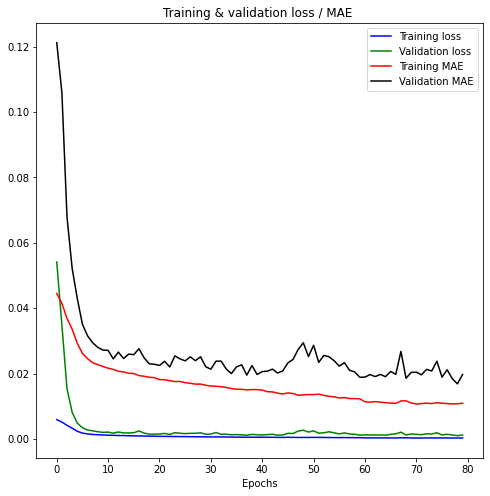

In [93]:
epoch_num=PARAMS['n_epochs']
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


plt.figure(figsize=(8,8))
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.plot(range(epoch_num), mae, 'r', label='Training MAE')
plt.plot(range(epoch_num), val_mae, 'k', label='Validation MAE')
plt.xlabel('Epochs')
plt.title('Training & validation loss / MAE ')
plt.legend()
plt.show()

### Predict on subset of validation set

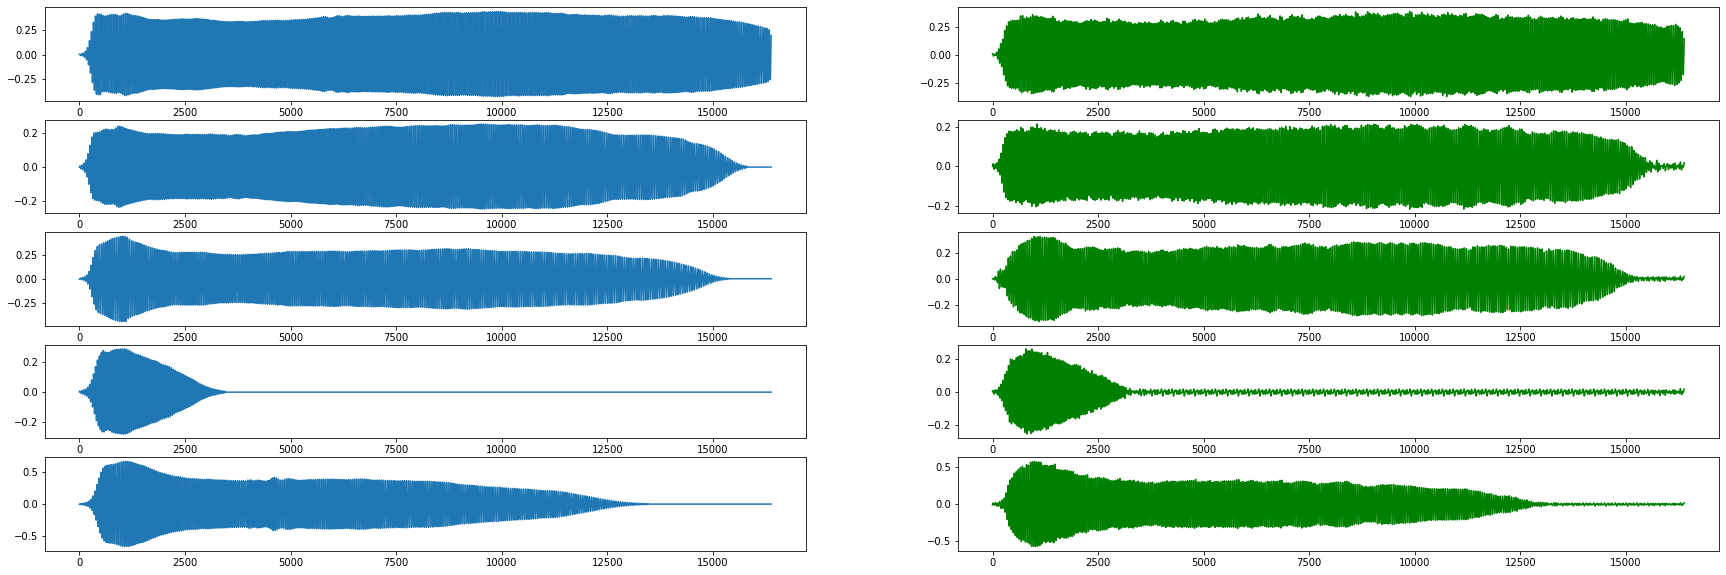

original 1


decoded 1


original 2


decoded 2


original 3


decoded 3


original 4


decoded 4


original 5


decoded 5


In [98]:
# choose number of examples from validation set to predict on and compare with original t-series signals

n = 5

orig_audio=[]
decoded_audio=[]
valid_dataset = create_datasets(valid_filenames)
fig,axes=plt.subplots(n,2,figsize=(30,10))
for i, (spectrogram, audio) in enumerate(valid_dataset.shuffle(100).take(n)):
    spectrogram=tf.expand_dims(spectrogram,axis=0)
    out=model.predict(spectrogram)
    out=np.squeeze(out,axis=-1)
    out=np.squeeze(out,axis=0)
    r=i
    ax=axes[r][0]
    ax.plot(audio)
    ax=axes[r][1]
    ax.plot(out,'g')

    orig_audio.append(audio)
    decoded_audio.append(out)
    
plt.show()

for i in range(n):
    display(IPython.display.Audio(orig_audio[i],rate=samplerate))
    print('original',i+1)
    display(IPython.display.Audio(decoded_audio[i],rate=samplerate))
    print('decoded',i+1)